# 4. Pretraining On Unlabeled Data

## 4.1 Evaluating Generative Text Models

### 4.1.1 GPT-124M Configuration Setup and Model Import

In [9]:
from gpt_modules import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 256,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

In [10]:
import torch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

### 4.1.2 Text-to-Tokens, Generation, and Decoding Pipeline

In [11]:
import tiktoken
from gpt_modules import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'}) # Encode text into token IDs (allow GPT special tokens if present)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension → shape becomes (1, seq_len)
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Remove batch dimension
    return tokenizer.decode(flat.tolist()) # Convert token IDs back to readable text


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

# Generate new tokens autoregressively
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

# Decode generated token IDs back into text
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### 4.1.3 Calculating The Text Generation Loss: Cross-Entropy And Perplexity

Example Input and Target Token Batches for Next-Token Prediction

In [12]:
inputs = torch.tensor([
    [16833, 3626, 6100],   # "every effort moves"
    [40,    1107, 588]     # "I really like"
])

targets = torch.tensor([
    [3626, 6100, 345],     # "effort moves you"
    [1107, 588, 11311]     # "really like chocolate"
])

Computing Token Probabilities from Model Logits

In [13]:
with torch.no_grad():                # Disable gradients for inference
    logits = model(inputs)           # Forward pass → raw logits (batch, seq_len, vocab_size)

probas = torch.softmax(logits, dim=-1)  # Convert logits to probabilities over vocabulary
print(probas.shape)                      # Expected: (batch_size, seq_len, vocab_size)

torch.Size([2, 3, 50257])


Selecting Most Probable Token IDs (Greedy Prediction)

In [14]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)  
# Select highest-probability token at each position (greedy decoding)

print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


Comparing Target Tokens with Model Predictions (Decoded Text)

In [15]:
# Decode target tokens for batch 1
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")

# Decode predicted token IDs for batch 1
# Flatten removes extra dimension from argmax output
print(f"Outputs batch 1: "
      f"{token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


Extracting Model Probabilities for Target Tokens

In [16]:
text_idx = 0
# Get probabilities assigned to the correct target tokens for batch 1
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
# Same extraction for batch 2
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


Computing Log Probabilities of Target Tokens

In [17]:
# Combine probabilities from both batches and convert to log-probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))

print(log_probas)  # Log probabilities used in cross-entropy / likelihood calculations

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


Computing Average Log Probability of Targets

In [18]:
# Compute average log probability across all target tokens
avg_log_probas = torch.mean(log_probas)

print(avg_log_probas)  # Higher (less negative) means better predictions

tensor(-10.7940)


Computing Negative Average Log Probability (Loss Value)

In [19]:
# Convert average log probability into negative log-likelihood (loss)
neg_avg_log_probas = avg_log_probas * -1

print(neg_avg_log_probas)  # Equivalent to cross-entropy style loss

tensor(10.7940)


Inspecting Logits and Target Tensor Shapes

In [20]:
print("Logits shape:", logits.shape)    # Expected: (batch_size, seq_len, vocab_size)
print("Targets shape:", targets.shape)  # Expected: (batch_size, seq_len)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


Flattening Logits and Targets for Loss Computation

In [21]:
# Merge batch and sequence dimensions to match loss function expectations
logits_flat = logits.flatten(0, 1)   # Shape: (batch_size * seq_len, vocab_size)
targets_flat = targets.flatten()     # Shape: (batch_size * seq_len)

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


Computing Cross-Entropy Loss for Next-Token Prediction

In [22]:
# Compute cross-entropy loss between predicted logits and true token IDs
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)

print(loss)  # Standard language modeling loss (negative log-likelihood)

tensor(10.7940)


### 4.1.4 Calculating the training and validation set losses

Loading Text Dataset and Counting Characters & Tokens

In [23]:
file_path = "../dataset/the_verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()
    
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


Splitting Dataset into Training and Validation Sets

In [24]:
train_ratio = 0.90                              # Use 90% of data for training
split_idx = int(train_ratio * len(text_data))   # Compute split index

train_data = text_data[:split_idx]              # Training portion of text
val_data = text_data[split_idx:]                # Validation portion

Creating Training and Validation DataLoaders for GPT Training

In [25]:
from gpt_modules import create_dataloader_v1
torch.manual_seed(123)  # Ensure reproducible dataset shuffling

# Training DataLoader
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],  # Sequence length
    stride=GPT_CONFIG_124M["context_length"],      # Non-overlapping chunks
    drop_last=True,
    shuffle=True,
    num_workers=0
)

# Validation DataLoader
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

Inspecting Batch Shapes from Training and Validation DataLoaders

In [26]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)   # Input tokens and target tokens per batch

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)   # Same check for validation data

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


Batch and Dataset Loss Computation Functions

In [27]:
def calc_loss_batch(input_batch, target_batch, model, device):
    """
    Compute cross-entropy loss for a single batch.

    Moves data to device, runs forward pass,
    flattens logits/targets for token-level loss.
    """

    input_batch = input_batch.to(device)     # Move inputs to CPU/GPU
    target_batch = target_batch.to(device)   # Move targets to same device
    logits = model(input_batch)              # Forward pass → (batch, seq_len, vocab_size)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten()) # Flatten batch + sequence dims for cross-entropy loss
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    """
    Compute average loss over a DataLoader.

    Optionally limit evaluation to a subset of batches
    (useful for faster validation during training).
    """

    total_loss = 0.

    # Handle empty loader edge case
    if len(data_loader) == 0:
        return float("nan")

    # Use all batches unless specified otherwise
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    # Iterate over batches
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()   # Accumulate scalar loss
        else:
            break

    # Return average loss per batch
    return total_loss / num_batches

Selecting Best Available Device (CUDA, MPS, or CPU)

In [35]:
# Prefer CUDA GPU → then Apple MPS → otherwise CPU
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.mps.is_available()
    else "cpu"
)

model.to(device)  # Move model to selected device

with torch.no_grad():  # Disable gradients for evaluation
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758273654514
Validation loss: 10.98110580444336


## 4.2 Training an LLM

### 4.2.1 Simple GPT Training Loop with Evaluation and Text Sampling

In [45]:
#Generate and Print Sample Text During Training

def generate_and_print_sample(model, tokenizer, device, start_context):
    """
    Generate a short text sample from the model during training.

    Useful for qualitative monitoring of model progress.
    Temporarily switches to evaluation mode for generation.
    """

    model.eval()  # Disable dropout and switch to inference mode

    # Maximum context length supported by positional embeddings
    context_size = model.pos_emb.weight.shape[0]

    # Encode starting text prompt and move to device
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    # Generate tokens autoregressively
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )

    # Decode tokens back to readable text
    decoded_text = token_ids_to_text(token_ids, tokenizer)

    # Print generated text in one line (remove line breaks)
    print(decoded_text.replace("\n", " "))

    model.train()  # Restore training mode

In [46]:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    """
    Train a GPT-style language model with periodic evaluation and sample generation.

    Tracks:
      - train_losses: training loss values measured during evaluation checkpoints
      - val_losses: validation loss values measured during evaluation checkpoints
      - track_tokens_seen: cumulative number of tokens processed at each checkpoint

    Args:
        model (nn.Module): GPT-style model to train.
        train_loader (DataLoader): Training data loader yielding (input_batch, target_batch).
        val_loader (DataLoader): Validation data loader yielding (input_batch, target_batch).
        optimizer (torch.optim.Optimizer): Optimizer used for parameter updates.
        device (torch.device): Device to run training on (cuda/mps/cpu).
        num_epochs (int): Number of full passes over the training data.
        eval_freq (int): Evaluate every eval_freq training steps.
        eval_iter (int): Number of batches to use for evaluation (speed vs accuracy tradeoff).
        start_context (str): Prompt text used for sample generation after each epoch.
        tokenizer: Tokenizer used for encoding/decoding text.

    Returns:
        tuple: (train_losses, val_losses, track_tokens_seen)
    """
    # Lists used to store loss curves and token progress over time
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Loop over epochs
    for epoch in range(num_epochs):
        model.train()  # Enable training mode (dropout, etc.)

        # Loop over batches
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients from previous step

            # Compute loss for current batch
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )

            loss.backward()        # Backpropagate gradients
            optimizer.step()       # Update model parameters

            # Track how many tokens have been processed so far
            tokens_seen += input_batch.numel()
            global_step += 1

            # Periodic evaluation on train/val sets
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )

        # Generate a sample after each epoch to qualitatively inspect progress
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

Model Evaluation Helper (Train & Validation Loss)

In [47]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """
    Evaluate model performance on training and validation sets.

    Temporarily switches the model to evaluation mode
    (disables dropout, etc.), computes average loss on a limited
    number of batches for speed, then restores training mode.

    Args:
        model (nn.Module): Model to evaluate.
        train_loader (DataLoader): Training dataset loader.
        val_loader (DataLoader): Validation dataset loader.
        device (torch.device): Computation device.
        eval_iter (int): Number of batches to evaluate.

    Returns:
        tuple: (train_loss, val_loss)
    """

    model.eval()  # Switch to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )

    model.train()  # Restore training mode

    return train_loss, val_loss

### 4.2.2 Initializing GPT Model, Optimizer, and Starting Training

In [48]:
torch.manual_seed(123)                    # Ensure reproducible initialization

model = GPTModel(GPT_CONFIG_124M)         # Initialize GPT model
model.to(device)                          # Move model to CPU/GPU/MPS

# AdamW optimizer commonly used for Transformer training
optimizer = torch.optim.AdamW(
    model.parameters(),                   # Model parameters to optimize
    lr=0.0004,                            # Learning rate
    weight_decay=0.1                      # Weight decay regularization
)

num_epochs = 10                           # Number of training epochs

# Start training loop with periodic evaluation and sample generation
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.817, Val loss 9.924
Ep 1 (Step 000005): Train loss 8.066, Val loss 8.332
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.619, Val loss 7.042
Ep 2 (Step 000015): Train loss 6.046, Val loss 6.596
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,, and,, the,, the, and,, and,,, the, and,,,,,,
Ep 3 (Step 000020): Train loss 5.524, Val loss 6.508
Ep 3 (Step 000025): Train loss 5.369, Val loss 6.378
Every effort moves you, and to the of the of the picture. Gis.                                     
Ep 4 (Step 000030): Train loss 4.830, Val loss 6.263
Ep 4 (Step 000035): Train loss 4.586, Val loss 6.285
Every effort moves you of the "I the picture.                    "I"I the picture"I had the picture"I the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.879, Val loss 6.130
Every effort moves you know he had been his pictures, and I felt it's by his last word.          

### 4.2.3 Plotting Training and Validation Loss Curves

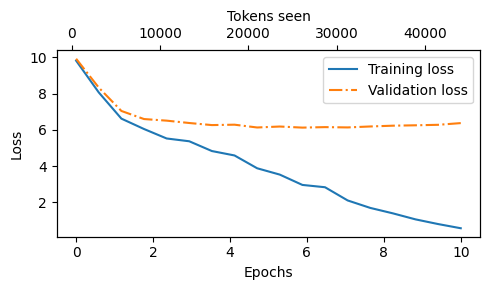

In [49]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    """
    Plot training and validation loss curves.

    Shows:
      - Loss vs epochs (primary x-axis)
      - Tokens processed vs loss (secondary x-axis)
    """

    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss vs epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses,
        linestyle="-.", label="Validation loss"
    )

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # Ensure integer tick marks for epochs
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Secondary x-axis showing tokens processed
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for alignment
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()


# Create evenly spaced epoch values matching number of recorded losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

# Plot loss curves
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 4.3 Decoding strategies to control randomness

Generating Text from Trained GPT Model

In [53]:
model.to("cpu"); # Move model to CPU for inference or saving
model.eval(); # Set evaluation mode (disable dropout, etc.)

tokenizer = tiktoken.get_encoding("gpt2")  # Load GPT-2 tokenizer

# Generate continuation from prompt
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

# Decode generated tokens back to text
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### 4.3.1 Temperature scaling

Defining Vocabulary and Inverse Mapping

In [55]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

# Reverse mapping: token ID → word
inverse_vocab = {v: k for k, v in vocab.items()}

Example Logits for Next-Token Prediction

In [56]:
# Simulated model output logits for the next token
# Higher value → higher predicted likelihood before softmax
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

Selecting Next Token via Softmax and Argmax

In [57]:
probas = torch.softmax(next_token_logits, dim=0)  # Convert logits to probabilities

# Pick highest-probability token ID (greedy decoding)
next_token_id = torch.argmax(probas).item()

# Map token ID back to word
print(inverse_vocab[next_token_id])

forward


Sampling Next Token from Probability Distribution

In [58]:
torch.manual_seed(123)  # Ensure reproducible sampling

# Sample token ID according to probability distribution
next_token_id = torch.multinomial(probas, num_samples=1).item()

# Convert sampled token ID back to word
print(inverse_vocab[next_token_id])

forward


Sampling Tokens Repeatedly to Inspect Distribution

In [59]:
def print_sampled_tokens(probas):
    # Fix random seed for reproducibility
    torch.manual_seed(123)

    # Sample 1000 token IDs according to probability distribution
    sample = [
        torch.multinomial(probas, num_samples=1).item()
        for _ in range(1_000)
    ]

    # Count how often each token ID appears
    sampled_ids = torch.bincount(torch.tensor(sample))

    # Print frequency of each sampled token
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


Softmax with Temperature Scaling

In [60]:
def softmax_with_temperature(logits, temperature):
    """
    Apply temperature scaling before softmax.

    Lower temperature → sharper distribution (more deterministic)
    Higher temperature → flatter distribution (more random)
    """

    scaled_logits = logits / temperature  # Adjust confidence via temperature
    return torch.softmax(scaled_logits, dim=0)  # Convert to probabilities

Visualizing Temperature Scaling Effects on Token Probabilities

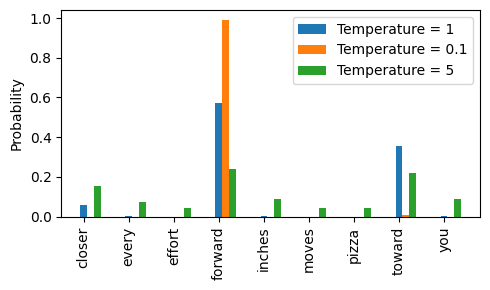

In [61]:
# Temperature values to compare
temperatures = [1, 0.1, 5]

# Compute probability distributions with different temperatures
scaled_probas = [
    softmax_with_temperature(next_token_logits, T)
    for T in temperatures
]

# Token index positions for plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))

# Plot probability bars for each temperature
for i, T in enumerate(temperatures):
    ax.bar(
        x + i * bar_width,
        scaled_probas[i],
        bar_width,
        label=f"Temperature = {T}"
    )

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

### 4.3.2 Top-k sampling

Top-K Token Selection from Logits

In [62]:
top_k = 3

# Get the top-K highest logits and their positions (token IDs)
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


Applying Top-K Filtering to Logits

In [63]:
# Replace logits outside the top-K with -inf so softmax ignores them
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],  # Values below kth largest logit
    input=torch.tensor(float('-inf')),             # Mask them out
    other=next_token_logits                        # Keep top-K logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


Computing Probabilities After Top-K Filtering

In [64]:
# Convert filtered logits into probabilities
topk_probas = torch.softmax(new_logits, dim=0)

print(topk_probas)  # Only top-K tokens retain non-zero probability

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## 4.4 A modified text generation function with more diversity

Advanced Text Generation with Temperature, Top-K, and EOS Control

In [65]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    """
    Flexible autoregressive text generation function.

    Supports:
      - Temperature sampling (controls randomness)
      - Top-K filtering (restricts candidate tokens)
      - Greedy decoding fallback
      - Early stopping on EOS token

    Args:
        model (nn.Module): GPT-style language model.
        idx (Tensor): Current token IDs (batch_size, seq_len).
        max_new_tokens (int): Number of tokens to generate.
        context_size (int): Maximum context window length.
        temperature (float): Sampling temperature (0 = greedy).
        top_k (int | None): Keep only top-K logits if specified.
        eos_id (int | None): End-of-sequence token ID to stop early.

    Returns:
        Tensor: Generated token IDs.
    """

    for _ in range(max_new_tokens):

        # Keep only most recent tokens within context window
        idx_cond = idx[:, -context_size:]

        # Model forward pass (inference mode)
        with torch.no_grad():
            logits = model(idx_cond)

        # Extract logits for next-token prediction
        logits = logits[:, -1, :]

        # Optional top-K filtering
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]

            # Mask out tokens below kth largest logit
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        # Temperature sampling
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)

            # Sample next token probabilistically
            idx_next = torch.multinomial(probs, num_samples=1)

        else:
            # Greedy decoding (most probable token)
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        # Optional early stop if EOS token generated
        if eos_id is not None and (idx_next == eos_id).any():
            break

        # Append predicted token to sequence
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [66]:
torch.manual_seed(123)  # Ensure reproducible sampling

# Generate text with controlled randomness
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,        # Restrict sampling to top 25 tokens
    temperature=1.4  # Increase randomness in sampling
)

# Decode generated tokens back to readable text
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand," she down." For Mrs. Gisburn! The women had


## 4.4 Loading and saving model weights in PyTorch

Saving Model Weights to File

In [67]:
torch.save(model.state_dict(), "model.pth")  
# Save model parameters (state_dict) for later loading or inference

Loading Saved Model Weights for Inference

In [69]:
model = GPTModel(GPT_CONFIG_124M)  
# Recreate model architecture

model.load_state_dict(torch.load("model.pth", map_location=device))  
# Load saved weights and map to current device

model.eval();
# Switch to evaluation mode (disable dropout, etc.)

Saving Model and Optimizer Checkpoint

In [70]:
torch.save(
    {
        "model_state_dict": model.state_dict(),        # Model weights
        "optimizer_state_dict": optimizer.state_dict() # Optimizer state for training resume
    },
    "model_and_optimizer.pth"
)

Loading Model and Optimizer from Checkpoint (Resume Training)

In [72]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
# Load saved checkpoint (model + optimizer states)

model = GPTModel(GPT_CONFIG_124M)  
# Recreate model architecture

model.load_state_dict(checkpoint["model_state_dict"])
# Restore model weights

optimizer = torch.optim.AdamW(
    model.parameters(), lr=5e-4, weight_decay=0.1
)
# Recreate optimizer with same hyperparameters

optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# Restore optimizer state (momentum, etc.)

model.train();  # Switch back to training mode

## 4.5 Loading pretrained weights from OpenAI

Downloading and Loading Pretrained GPT-2 Weights

In [75]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

/Users/galhavshush/Projects/LLM-from-scratch/venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 50.7kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 924kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 88.4kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:59<00:00, 4.15MiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 4.37MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 607kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 578kiB/s] 


Inspecting Loaded GPT-2 Settings and Parameters

In [86]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


Inspecting GPT-2 Token Embedding Weights

In [87]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


Configuring and Initializing a GPT-2 Sized Model (124M)

In [88]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"

NEW_CONFIG = GPT_CONFIG_124M.copy()      # Copy base GPT config
NEW_CONFIG.update(model_configs[model_name])  # Update with pretrained model specs

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

Assigning Pretrained Weights with Shape Check

In [89]:
def assign(left, right):
    """
    Convert a pretrained weight array/tensor into a trainable torch.nn.Parameter
    after verifying that shapes match.

    Args:
        left (Tensor | nn.Parameter): Existing model parameter (used for shape check).
        right (array-like | Tensor): Pretrained weights to assign.

    Returns:
        nn.Parameter: Parameter initialized from `right`.

    Raises:
        ValueError: If shapes do not match.
    """
    if left.shape != right.shape:
        raise ValueError(
            f"Shape mismatch. Left: {left.shape}, Right: {right.shape}"
        )

    # Wrap pretrained weights as a Parameter so they can live inside nn.Module
    return torch.nn.Parameter(torch.tensor(right))

Loading Pretrained GPT-2 Weights Into The Custom GPT Model

In [90]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    """
    Load pretrained GPT-2 weights (from `params`) into a GPTModel instance.

    This function maps weights from the GPT-2 checkpoint structure to your
    model's modules:
      - Token embeddings (wte) and positional embeddings (wpe)
      - Per-block attention weights (QKV projections + output projection)
      - Per-block MLP weights (c_fc and c_proj)
      - Per-block layer norm parameters (ln_1 and ln_2)
      - Final layer norm parameters
      - Output head weights (tied to token embeddings)

    Args:
        gpt (nn.Module): Your GPTModel instance (matching GPT-2 architecture).
        params (dict): Pretrained parameter dictionary returned by the loader.

    Returns:
        nn.Module: The same `gpt` model with updated parameters.
    """

    # Load positional embeddings and token embeddings
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    # Load parameters for each Transformer block
    for b in range(len(params["blocks"])):

        # GPT-2 stores Q, K, V projection weights concatenated in one matrix
        # Split c_attn weights into q_w, k_w, v_w along the last dimension
        q_w, k_w, v_w = np.split(
            params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1
        )

        # Assign Q, K, V projection weights (transpose to match PyTorch Linear layout)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T
        )
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T
        )
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T
        )

        # Split and assign Q, K, V projection biases
        q_b, k_b, v_b = np.split(
            params["blocks"][b]["attn"]["c_attn"]["b"], 3, axis=-1
        )
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b
        )
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b
        )
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b
        )

        # Attention output projection (c_proj)
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )

        # MLP first projection (c_fc)
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )

        # MLP second projection (c_proj)
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )

        # LayerNorm 1 parameters (ln_1): scale (g) and shift (b)
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"]
        )

        # LayerNorm 2 parameters (ln_2): scale (g) and shift (b)
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"]
        )

    # Final LayerNorm parameters
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])

    # Weight tying: output head shares weights with token embeddings
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

    return gpt

In [92]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

Generating Text Using Loaded GPT-2 Weights

In [97]:
torch.manual_seed(123)  # Ensure reproducible sampling

# Generate text using pretrained GPT weights
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,        # Restrict sampling to top 50 tokens
    temperature=1.5  # Increase randomness
)

# Decode tokens back to readable text
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward more efficient and efficient processes, like in the car's oil and gas operation," the study said. To see if that
